# Random Forest

## Loading train/test parquet from S3

In [11]:
import pandas as pd

path_train = "s3://crisk-nico-prod/curated/apps_merged_bureau_agg_1/"
path_test = "s3://crisk-nico-prod/curated/apps_merged_bureau_agg_test/"

df_train = pd.read_parquet(path_train, storage_options={"anon": False})
df_test = pd.read_parquet(path_test, storage_options={"anon": False})


## General information about data

* Glue ETL already standardized missingness & types
* Test set separation ensures unbiased evaluation
* dataset has 112 features and 1 binary label

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 113 entries, SK_ID_CURR to bucket_id
dtypes: category(1), float64(49), int64(51), object(12)
memory usage: 263.1+ MB


In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 112 entries, SK_ID_CURR to bucket_id
dtypes: category(1), float64(49), int64(50), object(12)
memory usage: 41.3+ MB


## Splitting features and target

* `SK_ID_CURR` = identifier
* `bucket_id` = technical partition

In [14]:
Xtrain = df_train.drop(["SK_ID_CURR", "TARGET", "bucket_id"], axis=1)
ytrain = df_train["TARGET"]

Xtest = df_test.drop(["SK_ID_CURR", "bucket_id"], axis=1)


## Detect categorical and numerical features in training dataset

In [15]:
categorical_features = (Xtrain.select_dtypes(include='object').copy()).columns
numerical_features = (Xtrain.select_dtypes(include='number').copy()).columns

## Preprocessing Pipeline

* In Random Forest, trees do not need scaling, we can skip normalization.
* **OneHotEncoder** enconde categorical feature through OneHotEncoding, Random Forest needs it to interpret them.
    * **drop='first':** avoids perfect multicollinearity, droping first columna (array of zeros).
    * **handle_unknown='ignore':** necessary for unseen categories in the test dataset.
* Create transformer `preprocess` for categorical features.


In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)


## Choosing Classifier (Random Forest)

For Random Forest, we implement the model provided by sklearn. We initialize some variables but we will play with those hyper-params through Random Search.

* **class_weight="balanced"** because balancing is required, with EDA analysis default represents only 8%, the dataset is highly imbalanced.


In [17]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(class_weight='balanced',n_estimators=750, max_depth=15 ,random_state=42)

Through Pipeline, it is possible to ensure same transformations applied at prediction stage.

In [18]:
from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RF)
])
clf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START',...
       'AMT_CREDIT_SUM_LIMIT_SUM', 'AMT_CREDIT_SUM_LIMIT_AVG',
       'AMT_CREDIT_SUM_OVERDUE_MAX', 'AMT_CREDIT_SUM_OVERDUE_SUM',
       'AMT_CREDIT_SUM_OVERDUE_AVG', 'CREDIT_TYPE_NUNIQUE',
       'DAYS_CREDIT_UPDATE_MAX', 'DAYS_CREDIT_UPDATE_AVG',
       'DAYS_ENDDATE_FACT_AVG', 'TOTAL_LOANS'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        n_estimators=750, random_state=42))])

## Hyperparameter Tuning

Implemented Random Search due to:

* **Efficiency:** It searches over a random subset of hyperparameter combinations, which can be much faster than testing every possible combination (which is what GridSearchCV does).
* **Flexibility:** We can define ranges or distributions for the hyperparameters, and it will sample from those ranges.

We will tune the following hyperparameters for RandomForest:

* **n_estimators:** Number of decision trees in the forest. We have to handle a good balance to get good performance and avoid computational cost of training and predicting.
* **max_depth:** The maximum depth of each decision tree in the forest.

We also implemented:
* we split training data into 3 folds through Cross-validation, so we train on 2th folds and validate on the 3rd.
* Evaluation metric **ROC** and **AUC**.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'model__n_estimators': np.arange(200, 500, 5),
    'model__max_depth': np.arange(10, 25, 5),
}

random_search = RandomizedSearchCV(
    clf,               
    param_distributions=param_dist,
    scoring='roc_auc',  
    cv=3,               
    verbose=3,          
    random_state=42,  
)

In [20]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    Xtrain, ytrain, test_size=0.2, random_state=42, stratify=ytrain
)
random_search.fit(X_tr, y_tr)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best AUC score: {random_search.best_score_:.4f}")

c:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END model__max_depth=10, model__n_estimators=320;, score=0.732 total time= 3.7min
[CV 2/3] END model__max_depth=10, model__n_estimators=320;, score=0.728 total time= 4.0min
[CV 3/3] END model__max_depth=10, model__n_estimators=320;, score=0.731 total time= 4.1min
Best parameters: {'model__n_estimators': 320, 'model__max_depth': 10}
Best AUC score: 0.7306


This stage, we retrained the model but this time with best hyper-parameters. Therefore, make prediction with the validation dataset to analyze possible overfitting and model performance.

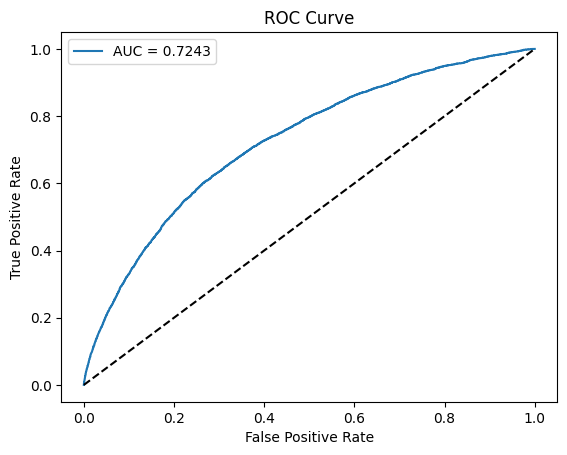

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

best_clf = random_search.best_estimator_

best_clf.fit(X_tr, y_tr)

y_val_proba = best_clf.predict_proba(X_val)[:, 1] 


fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


There is not overfitting due to similar AUC values in training and validation datasets. They reach around **72%**. 

## Confusion Matrix & Metrics

G-Mean is a metric used in imbalanced classification to balance:

* Sensitivity (Recall for the minority class)
* Specificity (1 – FPR for the majority class)

It rewards thresholds where the classifier:
1. Catches many positive cases
2. Makes few false positives

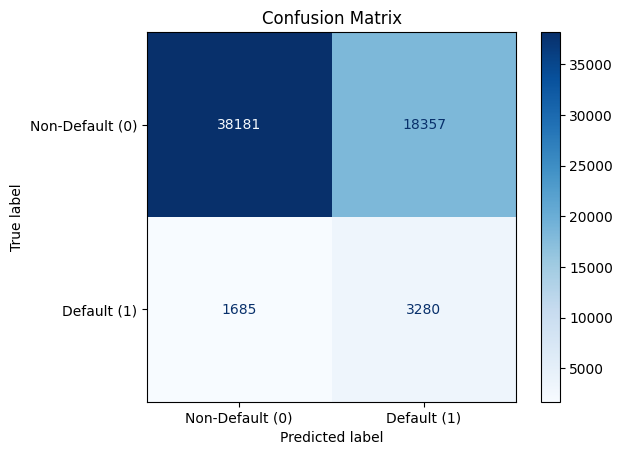

Best Threshold: 0.47299715785118923
G-Mean: 0.667929652287544

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56538
           1       0.15      0.66      0.25      4965

    accuracy                           0.67     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.67      0.75     61503



In [22]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report
)

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]

y_pred_gmean = (y_val_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_val, y_pred_gmean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Non-Default (0)", "Default (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print("Best Threshold:", best_threshold)
print("G-Mean:", gmeans[ix])

print("\nClassification Report:")
print(classification_report(y_val, y_pred_gmean))


### Analysis:
* **Recall**: The model catches around 65% of defaults, this represents a good value because, for this task, missing a default (False Negative) is worse than rejecting a good client (False Positive). Models aims is to reduce False Negative (high Recall).
* **Precision**: The model catches around 15% of precision. However this is expected due to imbalanced dataset, so many cases the precision for imbalanced tasks is not considered.
* **Threshold**: The best threshold found was 0.37, and G-mean gotten was 0.665.

## Model Coefficients

Unlike Logistic Regression or Linear Models, Random Forests do NOT have coefficients because they are non-linear, tree-based models.

In a Random Forest, feature importance measures how much each feature contributes to reducing impurity across all trees. The higher the importance, the more the model relies on that feature for its decisions.

In [23]:
transform_col = best_clf.named_steps['preprocess']

# Get the feature names after OneHotEncoding
encoded_columns = transform_col.get_feature_names_out()

rf_model = best_clf.named_steps['model']
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': encoded_columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df.head(10)

,Feature,Importance
149,num__EXT_SOURCE_2,0.150146
150,num__EXT_SOURCE_3,0.136057
200,num__DAYS_CREDIT_AVG,0.038361
131,num__DAYS_BIRTH,0.034632
132,num__DAYS_EMPLOYED,0.029790
221,num__DAYS_CREDIT_UPDATE_AVG,0.029229
198,num__DAYS_CREDIT_MAX,0.027935
204,num__DAYS_CREDIT_ENDDATE_AVG,0.021552
199,num__DAYS_CREDIT_MIN,0.021075
154,num__DAYS_LAST_PHONE_CHANGE,0.020812


# Evaluate Test Dataset and Create Submission

Finally, we will re-train the model, but now with whole training dataset and predict `y_test` to create the submission.

In [24]:
X_train, X_test, y_train = Xtrain, Xtest, ytrain
best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START',...
       'AMT_CREDIT_SUM_LIMIT_SUM', 'AMT_CREDIT_SUM_LIMIT_AVG',
       'AMT_CREDIT_SUM_OVERDUE_MAX', 'AMT_CREDIT_SUM_OVERDUE_SUM',
       'AMT_CREDIT_SUM_OVERDUE_AVG', 'CREDIT_TYPE_NUNIQUE',
       'DAYS_CREDIT_UPDATE_MAX', 'DAYS_CREDIT_UPDATE_AVG',
       'DAYS_ENDDATE_FACT_AVG', 'TOTAL_LOANS'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=320, random_state=42))])

In [25]:
from sklearn.metrics import roc_auc_score

y_train_proba = best_clf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)

print(f"Train AUC: {train_auc:.4f}")

Train AUC: 0.7913


In [26]:
ytest = best_clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': df_test['SK_ID_CURR'],
    'TARGET': ytest
})


s3_file_path = 's3://crisk-nico-prod/predictions/submissions/submission_random_forest.csv'

submission.to_csv(s3_file_path, index=False)

# Model Summary

**Model Type**

* A Random Forest Classifier is an ensemble model composed of many decision trees, where each tree is trained on different random subsets of features and observations.
* Predictions are produced by aggregating all trees’ outputs, which reduces variance and improves robustness compared to a single tree.

**Performance**

* Train AUC shows 79.13%.
* Test AUC around 72.30% (Based on Kaggle score).
* Good recall of defaults around 66%.

**Interpretability**

* Random Forest interpretability is moderate, not as transparent as logistic regression but still analyzable.

**Strengths**

* Captures non-linear patterns.
* Handles interactions between features automatically.
* Robust to noise, outliers, and irrelevant variables.
* Feature importance aligns with domain intuition, strengthening trust.

**Weaknesses**

* Overfits training data.
* Poor probability calibration.
* Interpretability limited (No coefficients, Harder to justify decisions).
* High computational cost.